In [1]:
import os
import gc
from tqdm import tqdm
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
import math

# %matplotlib widget
basePath = "./sims.TNG/TNG100-1/output"

initial_snapshot = 69
end_snapshot = 99

halos_fields = ["GroupFirstSub", "GroupNsubs", "GroupMass", "GroupPos"]
subhalos_fields = ["SubhaloGrNr", "SubhaloMass", "SubhaloPos"]
tree_fields = ["SubfindID", "SnapNum"]

h = 0.6774  # km/Mpc

m_dm = 4.5e-5  # E10M_Sum
m_dm_h = m_dm * h

Critial_Density = 1.27e-8  # E10M_Sum/kpc^3
Critial_Density_h = Critial_Density / h**2  # E10M_Sum/(kpc/h)^3


def Detect_Mkdir(Path):
    if not (os.path.exists(Path)):
        os.makedirs(Path)
    return Path


FilePath = Detect_Mkdir(os.path.join('./TNG100_Final_File'))
Final_File_List = ['Halo_Array', 'Host_Array', 'MMS_Array', 'First_App_Snap_Array', 'First_App_Distance_Array',
                   'Snap99_Distance_Array', 'Snap99_Radial_Velocity_Array', 'Snap99_Virial_Radius_Array', 'Is_First_Approach', 'Is_First_Infall']
for filename in Final_File_List:
    if os.path.exists(os.path.join(FilePath, filename)+'.npy'):
        globals()[filename] = np.load(
            (os.path.join(FilePath, filename)+'.npy'))


In [2]:
def Calculate_Halo_Dict(halo_index, host_index, mms_index):

    host_tree = il.sublink.loadTree(
        basePath, end_snapshot, host_index, fields=tree_fields, onlyMPB=1)
    mms_tree = il.sublink.loadTree(
        basePath, end_snapshot, mms_index, fields=tree_fields, onlyMPB=1)

    satellite_velocity_list = list()
    host_mms_distance = list()
    host_position_list = list()
    mms_position_list = list()

    for current_snapshot in range(initial_snapshot, end_snapshot+1):

        header = il.groupcat.loadHeader(basePath, current_snapshot)
        scale_factor = header['Time']
        host_subhalo_index = host_tree['SubfindID'][np.where(
            host_tree['SnapNum'] == current_snapshot)[0]]
        mms_subhalo_index = mms_tree['SubfindID'][np.where(
            mms_tree['SnapNum'] == current_snapshot)[0]]

        if len(mms_subhalo_index) == 0 or len(host_subhalo_index) == 0:
            satellite_velocity_list.append(0)
            host_mms_distance.append(0)
            host_position_list.append(np.array([0, 0, 0]))
            mms_position_list.append(np.array([0, 0, 0]))
            continue

        host_subhalo_dict = il.groupcat.loadSingle(
            basePath, current_snapshot, -1, host_subhalo_index)
        mms_subhalo_dict = il.groupcat.loadSingle(
            basePath, current_snapshot, -1, mms_subhalo_index)

        current_host_comoving_position = host_subhalo_dict['SubhaloPos']
        current_mms_comoving_position = mms_subhalo_dict['SubhaloPos']

        current_host_physical_position = current_host_comoving_position*scale_factor
        current_mms_physical_position = current_mms_comoving_position*scale_factor

        current_host_physical_position = current_host_physical_position % 35000
        current_mms_physical_position = current_mms_physical_position % 35000

        current_difference_physical_coordinates = current_mms_physical_position - \
            current_host_physical_position
        distance = np.linalg.norm(current_difference_physical_coordinates)

        host_velocity = host_subhalo_dict['SubhaloVel']
        mms_velocity = mms_subhalo_dict['SubhaloVel']

        Vel_diff = mms_velocity-host_velocity
        Vel_Radius = np.dot(
            Vel_diff, current_difference_physical_coordinates)/distance

        satellite_velocity_list.append(Vel_Radius)
        host_mms_distance.append(distance)
        gc.collect()

    satellite_radial_velocity = np.array(satellite_velocity_list)
    host_mms_distance = np.array(host_mms_distance)
    return_data = dict()
    return_data['RadialVelocity'] = satellite_radial_velocity
    return_data['Distance'] = host_mms_distance
    return_data['Snapshots'] = np.arange(initial_snapshot, end_snapshot+1)
    return return_data


def Extremum_Calculation(Distance_Array, Virial_Radius):
    Extremum_Number = 0
    for index in np.arange(1, len(Distance_Array)-1):
        if (Distance_Array[index-1]-Distance_Array[index])*(Distance_Array[index]-Distance_Array[index+1]) < 0 and Distance_Array[index] <= 2*Virial_Radius:
            Extremum_Number += 1
    return Extremum_Number


In [3]:
virial_radius = il.groupcat.loadHalos(basePath, 99, fields=['Group_R_Crit200'])


Text(0.5, 1.0, 'Virial Radius of Subhalos And Halos')

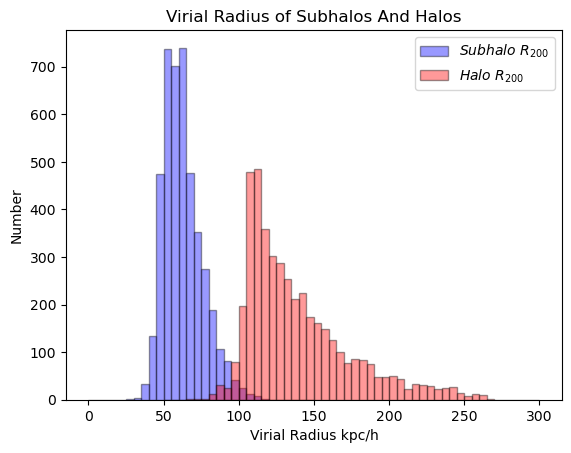

In [4]:
plt.hist(Snap99_Virial_Radius_Array, bins=30, range=[
         0, 150], histtype='bar', edgecolor='black', color='blue', alpha=0.4, label='$Subhalo\ R_{200}$')
plt.hist(virial_radius[Halo_Array], bins=50, range=[50, 300], histtype='bar',
         edgecolor='black', color='red', alpha=0.4, label='$Halo\ R_{200}$')
plt.legend()
plt.xlabel('Virial Radius kpc/h')
plt.ylabel('Number')
plt.title('Virial Radius of Subhalos And Halos')


In [9]:
FilePath = Detect_Mkdir(os.path.join('./TNG100_Final_File'))
filename = 'Is_First_Infall'
if os.path.exists(os.path.join(FilePath, filename)+'.npy'):
    globals()[filename] = np.load(
        (os.path.join(FilePath, filename)+'.npy'))
else:
    Is_First_Infall = np.array([])

start_sub_index = Is_First_Infall.shape[0]
step_length = 100
end = start_sub_index+step_length

if end > Halo_Array.shape[0]:
    end = Halo_Array.shape[0]
Final_File_Is_First_Infall = list()

for Subindex in tqdm(range(start_sub_index, end)):
    Halo_Index = Halo_Array[Subindex]
    Host_Index = Host_Array[Subindex]
    MMS_Index = MMS_Array[Subindex]

    halo_dict = Calculate_Halo_Dict(Halo_Index, Host_Index, MMS_Index)
    If_Distance_99_Within_2VirialRadius = (
        halo_dict['Distance'][end_snapshot-initial_snapshot] <= 2*Snap99_Virial_Radius_Array[Subindex])
    If_Extremun_Num_Less_2 = (Extremum_Calculation(
        halo_dict['Distance'], Snap99_Virial_Radius_Array[Subindex]) <= 1)
    If_First_Infall = If_Distance_99_Within_2VirialRadius and If_Extremun_Num_Less_2
    Final_File_Is_First_Infall.append(If_First_Infall)


Final_File_Is_First_Infall_Array = np.array(Final_File_Is_First_Infall)


  2%|▏         | 2/100 [00:10<08:28,  5.19s/it]

In [8]:
print(Halo_Array[:100][Final_File_Is_First_Infall_Array])
print(Host_Array[:100][Final_File_Is_First_Infall_Array])
print(MMS_Array[:100][Final_File_Is_First_Infall_Array])


[367 377 424 430]
[371704 373951 383945 385115]
[371705 373952 383946 385116]


In [46]:
Halo_Array


array([ 305,  328,  329, ..., 5077, 5087, 5537])

In [ ]:

if os.path.exists(os.path.join(FilePath, filename)+'.npy'):
    Previous_File = np.load((os.path.join(FilePath, filename)+'.npy'))
    Next_File_Name = 'Final_File_'+filename
    Next_File_Array = globals()[Next_File_Name]
    ConCated_File = np.concatenate(
        (Previous_File, Next_File_Array), axis=0)
    np.save((os.path.join(FilePath, filename)+'.npy'), ConCated_File)
else:
    File_Name = 'Final_File_'+filename
    File_Array = globals()[File_Name]
    np.save((os.path.join(FilePath, filename)+'.npy'), File_Array)
